# Recommendations with IBM

In this notebook, I will be building the recommendation system with the data from the IBM Watson Studio platform.   

By following the table of contents, I will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df['article_id'].nunique()

714

In [3]:
# Show df_content to get an idea of the data
df_content.head(n=100)
df_content['article_id'].nunique()

1051

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
user_by_article = df.groupby(['email', 'article_id']).size().unstack()

In [5]:
# the distribution of how many articles a user interacts with in the dataset 
interactions_count= df.groupby(['email']).size()

(array([2.63013693e-02, 8.93657918e-04, 2.46157271e-04, 5.88636952e-05,
        3.74587151e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.07024900e-05]),
 array([  1. ,  37.3,  73.6, 109.9, 146.2, 182.5, 218.8, 255.1, 291.4,
        327.7, 364. ]),
 <a list of 10 Patch objects>)

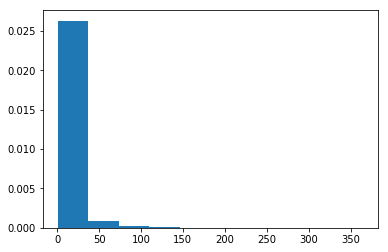

In [6]:
# visualize the distribution of the number of interactions 
plt.hist(interactions_count, density = True)

In [7]:
#  median and maximum number of user_article interactios below

median_val = np.median(interactions_count) # 50% of individuals interact with ____ number of articles or fewer.

max_views_by_user = np.max(interactions_count) # The maximum number of user-article interactions by any 1 user is ______.

print(median_val, max_views_by_user )

3.0 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
for col in df_content.columns:
    count_dup = df_content.duplicated(subset = [col], keep = 'first' ).sum()
    print(" the number of duplicates in {} is {}".format(col, count_dup))

 the number of duplicates in doc_body is 19
 the number of duplicates in doc_description is 33
 the number of duplicates in doc_full_name is 5
 the number of duplicates in doc_status is 1055
 the number of duplicates in article_id is 5


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = ['article_id'], keep = 'first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
print(unique_articles )
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
print(total_articles )
unique_users = df['email'].nunique() # The number of unique users
print(unique_users)
user_article_interactions = df.shape[0] # The number of user-article interactions
print(user_article_interactions)

714
1051
5148
45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
# summary table by article_id 
article_views = df['article_id'].value_counts().sort_values(ascending = False).head()
most_viewed_article_id = str(article_views.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views =article_views.iloc[0] # The most viewed article in the dataset was viewed how many times?

In [12]:
print(most_viewed_article_id)
print(max_views)

1429.0
937


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_view = df.groupby(['article_id', 'title']).size().reset_index().sort_values(by =[0],ascending = False )
    top_articles = article_view.iloc[:n,]['title']
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_view = df.groupby(['article_id', 'title']).size().reset_index().sort_values(by =[0],ascending = False )
    top_articles = article_view.iloc[:n,]['article_id'].astype(str)
    return top_articles # Return the top article titles from df (not df_content)
 
    return top_articles # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

699           use deep learning for image classification
625          insights from new york car accident reports
701                       visualize car data with brunel
697    use xgboost, scikit-learn & ibm watson machine...
652    predicting churn with the spss random tree alg...
614         healthcare python streaming application demo
600    finding optimal locations of new store using d...
526             apache spark lab, part 1: basic concepts
518              analyze energy consumption in buildings
608    gosales transactions for logistic regression m...
Name: title, dtype: object
699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
614    1314.0
600    1293.0
526    1170.0
518    1162.0
608    1304.0
Name: article_id, dtype: object


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
print(type(df['article_id']))
df.head()

<class 'pandas.core.series.Series'>


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df1 = df[['user_id', 'article_id']]
    df1['count'] =1 
    print(df1.head())
    user_item = df1.groupby(['user_id', 'article_id']).size().unstack()
    user_item[user_item>0] = 1
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

user_item

   user_id  article_id  count
0        1      1430.0      1
1        2      1314.0      1
2        3      1429.0      1
3        4      1338.0      1
4        5      1276.0      1


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    similarity_user_list  = []
    user_interaction = np.array(user_item.loc[user_id])
   
    for user in user_item.index.tolist(): 
        if user != user_id:
            a_user_array = np.array(user_item.loc[user])
            similarity = np.dot(user_interaction,a_user_array )
            similarity_user_list.append([user, similarity]) 
    similarity_user_list.sort(key= lambda x: x[1], reverse = True)
    print(type(similarity_user_list))
    most_similar_users  = [i[0] for i in similarity_user_list]
        
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of  function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

<class 'list'>
The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
<class 'list'>
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
<class 'list'>
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [24]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


`3.` Now that we have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_ids = [float(i) for i in article_ids]
    df = df.drop_duplicates('article_id',  keep = 'first')
    df2 = df.loc[df['article_id'].isin(article_ids)]     
    article_names = df2['title'].tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_ids = user_item.loc[:, user_item.loc[user_id,:] != 0].columns.values
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids, df)
    #print(article_ids)
    return article_ids , article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = []
    ids, titles  =  get_user_articles(user_id)
    neighbor_users = find_similar_users(user_id)
    for neighbor in neighbor_users: 
        neighbor_ids,  neighbor_titles = get_user_articles(neighbor, user_item=user_item)
        new_titles = np.setdiff1d(neighbor_titles, titles )
        #print(neighbor)
        #print(neighbor_titles)
        recs = np.unique(np.concatenate((recs, new_titles), axis = 0))
        if len(recs) > m: 
            break 
        
    
    return recs # return your recommendations for this user_id    

In [26]:
# Check Results
#get_article_names(['1429.0','1330.0'])
#user_user_recs(1,10) # Return 10 recommendations for user 1
#get_article_names(['1024.0'], df = df)
get_user_articles(1, user_item=user_item)

(['43.0',
  '109.0',
  '151.0',
  '268.0',
  '310.0',
  '329.0',
  '346.0',
  '390.0',
  '494.0',
  '525.0',
  '585.0',
  '626.0',
  '668.0',
  '732.0',
  '768.0',
  '910.0',
  '968.0',
  '981.0',
  '1052.0',
  '1170.0',
  '1183.0',
  '1185.0',
  '1232.0',
  '1293.0',
  '1305.0',
  '1363.0',
  '1368.0',
  '1391.0',
  '1400.0',
  '1406.0',
  '1427.0',
  '1429.0',
  '1430.0',
  '1431.0',
  '1436.0',
  '1439.0'],
 ['using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'use deep learning for image classification',
  'classify tumors with machine learning',
  'apache spark lab, part 1: basic concepts',
  'access db2 warehouse on cloud and db2 with python',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model',
  'welcome to pixiedust',
  'uci ml repository: chronic kidney disease data set',
  'time series prediction usin

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_array = np.array(user_item.loc[user_id])
    user_list = []
    similarity_list =[]
    num_interaction_list = []
    for user in user_item.index: 
        if user != user_id: 
            
            neighbor_array = np.array(user_item.loc[user])
            similarity = np.dot(user_array, neighbor_array)
            num_interaction = df[df['user_id'] == user].shape[0]
            user_list.append(user)
            similarity_list.append(similarity)
            num_interaction_list.append(num_interaction)
            
    neighbors_df = pd.DataFrame({'user_id': user_list, 'similarity': similarity_list, 'num_interaction': num_interaction_list})
    neighbors_df = neighbors_df.sort_values(by = [ 'similarity',  'num_interaction'], ascending =[False, False])
        
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # if user is old user, get the article id and articles name that user already interacted ; 
    # if user is new, immedidately return the the top m most interacted articles for recommendation 
    try: 
         aricle_ids , aricle_names = get_user_articles(user_id)
    except KeyError: #user does not exist
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    
    # Your code here
    #aricle_ids , aricle_names =  get_user_articles(user_id, user_item=user_item)
    rec_ids =np.array([])
   
    neighbors_df =  get_top_sorted_users(user_id, df=df, user_item=user_item)
    
    
    for neighbor in neighbors_df['user_id']:
        neighbor_article_ids, neighbor_article_names = get_user_articles(neighbor, user_item=user_item)
        new_ids = np.setdiff1d(neighbor_article_ids, aricle_ids, assume_unique = True)
        rec_ids = np.unique(np.concatenate([new_ids, rec_ids], axis=0)) 
        if len(rec_ids) >= m:
            
            break 
    rec_names =  get_article_names(rec_ids)  
    
    return rec_ids, rec_names

In [29]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Quick spot check - don't change this code - just use it to test your functions
#get_top_sorted_users(20, df=df, user_item=user_item)
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0' '1162.0' '1163.0' '1166.0' '1170.0' '1172.0' '1176.0'
 '12.0' '125.0' '1276.0' '1278.0' '1296.0' '1304.0' '1324.0' '1329.0'
 '1330.0' '1331.0' '1335.0' '1336.0' '1338.0' '1346.0' '1351.0' '1354.0'
 '1356.0' '1357.0' '1360.0' '1364.0' '1367.0' '1368.0' '1386.0' '1391.0'
 '1396.0' '1407.0' '1409.0' '1410.0' '1411.0' '142.0' '1420.0' '1424.0'
 '1426.0' '1427.0' '1433.0' '1444.0' '164.0' '205.0' '302.0' '336.0'
 '362.0' '465.0' '555.0' '651.0' '681.0' '686.0' '730.0' '761.0' '793.0'
 '880.0' '911.0' '939.0' '981.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with th

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).iloc[0]['user_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9]['user_id']# Find the 10th most similar user to user 131

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [33]:
sol_5_dict

{'The user that is most similar to user 1.': 3933.0,
 'The user that is the 10th most similar to user 131': 242.0}

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
If we were given a new user, none of the functions above can be used for make recommendations since we don't have the matrix of how the new user interact with some items before. So we can't use the collobrative filtering to make the recommendation to those new user. Instead, we can use Rank-Based Recommendations to recommend the most viewed articles to the new users.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [34]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs, _ = user_user_recs_part2(new_user, m=10) 
# Please note that in the user_user_recs_part2,
# I already use try except to account the the case of new user, by specify the case of new user
# and use the  get_top_article_ids(m) to recommend the 10 most viewed article to new user. 



In [35]:
new_user_recs

699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
614    1314.0
600    1293.0
526    1170.0
518    1162.0
608    1304.0
Name: article_id, dtype: object

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**
This project is different from the lesson as, the user_item matrix in this problem doesn't contain the NaN values. It composes of 1 and 0 value, in which 1 indicates for there is interaction between the user and article, and 0 indicates there is no interaction between user and article. 
Therefore, in this project we can use SVD instead of FunkSVD. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

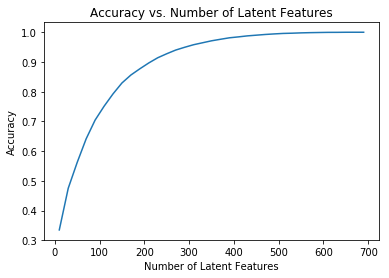

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)
def map_matrix(matrix):
    matrix[matrix >0 ] =1 
    matrix = matrix.fillna(0)
    return matrix

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id']).size().unstack()
    user_item_train = map_matrix(user_item_train)
    user_item_test  = df_test.groupby(['user_id', 'article_id']).size().unstack()
    # convert to binary matrix 
    user_item_test  = map_matrix(user_item_test)
    
    # get the user_id and article id 
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    train_idx = user_item_train.index
    train_arts = user_item_train.columns
    # Your code here.uni
    
    return user_item_train, user_item_test, train_idx, train_arts,  test_idx, test_arts

user_item_train, user_item_test,  train_idx, train_arts, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [42]:
print(len(np.setdiff1d(test_idx, train_idx)))
print(len(np.setdiff1d(test_arts, train_arts)))

662
0


In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [44]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below


In [45]:
# get the user_id list in the test set and also in the train set 
common_userid = np.intersect1d(train_idx, test_idx)
# get the article_id list in the test set and also in the train set 
common_articleid = np.intersect1d(train_arts, test_arts)
    
# We have the user id and article id in the test set that appear in the train set,
# now we need to find the position those user_id and article_id since the u and vt array doesn't contain the index 

# get the row position of the users in the test set that are available in the train set 
commonusers_position = np.arange(len(train_idx))[np.in1d( train_idx, test_idx)]
    
# get the row position of the articles  in the test set that are available in the train set 
commonarticles_position = np.arange(len(train_arts))[np.in1d(train_arts , test_arts)] 

 # get the subset of the u_train array that corresponding to the 20 users in the test set  
u_test = u_train[commonusers_position , :]
 # get the subset of the v_train array that corresponding to the 574 articles in the test set 
vt_test = vt_train[:, commonarticles_position]

s_test = s_train 
  
# get the subset of the test data set that corresponding to the user 
old_user_article = user_item_test.loc[common_userid, common_articleid ]


In [46]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
for k in num_latent_feats: 
    u_test_new, s_test_new, vt_test_new  = u_test[:, :k], np.diag(s_test[:k]), vt_test[:k, :]
    # get the prediction of the interaction from 
    old_user_article_predict = np.round(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    # diffs btw the prediction and the true value 
    diffs = np.subtract(old_user_article_predict, old_user_article )
    error = np.sum(np.sum(np.abs(diffs)))
   
    sum_errs.append(error)


In [47]:
a  = [2, 4, 6, 8, 10, 12]
b = [1, 2, 3, 4]
c = np.array([[1,2,3], [4,5,6] , [7,8,9]])

indices = np.arange(len(a))[np.in1d(a, b)]
indices
  
print(sum_errs)

[248.0, 269.0, 283.0, 303.0, 318.0, 339.0, 350.0, 359.0, 367.0, 375.0, 383.0, 387.0, 393.0, 397.0, 400.0, 404.0, 404.0, 406.0, 406.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0, 408.0]


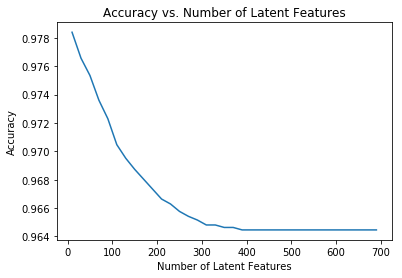

In [48]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(20*574));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


From the graph above, we can see that when the number of features increases, the accuracy decreases. It doesn't seem to make sense. 
I think the problem comes from the way we define the error and accuracy in the test set. 

Recall that we split the original data into the train set and test set. For those users in the test set that also appear in the train set, the set of articles they interact in the test set may not include the articles that user already interacted in the train set. Therefore the "user_item_test"  matrix composes of zero interaction for those users and those articles which there is an interaction between them in the training set. If the SVD from the training data frame user-item matrix can predict well the interaction between user and article in training data frame, but since that interaction did not appear in the test set, that will increase the errors, or reduce the accuracy. 

In my opinion, we do the SVD in the training set, but we need to test it on the entire data frame instead of the test set only. 

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

To evaluate if the recommendation system can make an improvement to how users can find articles, we can use A/B testing to test whether the outcome between having the recommendation is different from having no recommendation. The outcome metrics can be: 
* the length of time user spends per article that he/she interacts.
* the number of articles that user will interact per page visit. 
 
If the result of A/B testing indicates that the outcome metric is statistically significantly higher when there is recommendation than when there isn't, then we can conclude that the recommendation system can make an improvement.  

In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0